# 泰坦尼克事件的乘客信息数据分析与预测

本文将首先对泰坦尼克数据集进行清洗和重构，使之能够被模型学习；

而后使用逻辑回归和随机森林分类器分别训练模型，并使用常见的分类指标如混淆矩阵等对模型的分类能力进行评估；

最后使用梯度提升树训练模型，并解释模型的决策逻辑，进一步分析泰坦尼克数据集乘客的生存率与何种特征有关，构成数据分析的闭环。

# 一、数据清洗和重构

## 1. 导入库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['figure.figsize'] = (10, 6)  # 设置输出图片大小
%matplotlib inline

## 2. 载入数据

In [21]:
df_train = pd.read_csv("./datasets/titanic/train.csv")
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## 3. 数据清洗

包括数据去重、Nan清洗、数据分箱和文本处理。

> cut除了按照值进行分箱外，还可以按照数量进行分箱，第二个参数为整数即可。
> 除cut外，还有qcut可以按照百分比进行分箱。



In [22]:
df_train.fillna(0, inplace=True)

In [23]:
df_train.drop_duplicates(keep='first', inplace=True, ignore_index=True)

In [24]:
#将类别文本转换为one-hot编码

#方法一: OneHotEncoder
for feat in ["Embarked", "Sex"]:
#     x = pd.get_dummies(df["Age"] // 6)
#     x = pd.get_dummies(pd.cut(df['Age'],5))
    x = pd.get_dummies(df_train[feat], prefix=feat)
    df_train = pd.concat([df_train, x], axis=1)
    #df[feat] = pd.get_dummies(df[feat], prefix=feat)
    
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_0,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S,0,0,0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,0,0,0,1,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,0,0,1,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S,0,0,0,1,0,1


只保留可学习的部分

In [28]:
# [Pclass	Age	SibSp	Parch	Fare	Sex_female	Sex_male	Embarked_C	Embarked_Q	Embarked_S]
df_train_labels = df_train['Survived']
df_train_data = df_train.drop(columns=["Survived", "Name", "Sex", "Ticket", "Cabin", "Embarked", "Embarked_0"])
df_train_data.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,1,3,22.0,1,0,7.2500,0,0,1,0,1
1,2,1,38.0,1,0,71.2833,1,0,0,1,0
2,3,3,26.0,0,0,7.9250,0,0,1,1,0
3,4,1,35.0,1,0,53.1000,0,0,1,1,0
4,5,3,35.0,0,0,8.0500,0,0,1,0,1


In [29]:
df_train.to_csv("./datasets/titanic/cleaned_train.csv")

# 二、模型搭建

## 1. 数据切分

In [30]:
data = df_train_data
labels = df_train_labels

In [31]:
from sklearn.model_selection import train_test_split
# 对数据集进行切割
X_train, X_test, y_train, y_test = train_test_split(data, labels, stratify=labels, random_state=42)
# 查看数据形状
X_train.shape, X_test.shape

((668, 11), (223, 11))

使用train_test_split切分源数据集得到训练集和测试集，也可以使用交叉验证方法

注意随机打乱random_state，在处理时序数据的时候不能打乱。

## 2. 模型创建

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [33]:
# 默认参数逻辑回归模型
lr = LogisticRegression()
lr.fit(X_train, y_train)
# 查看训练集和测试集score值
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Testing set score: {:.2f}".format(lr.score(X_test, y_test)))

Training set score: 0.79
Testing set score: 0.76


c:\users\zyt\pycharmprojects\tf2_env\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [34]:
# 调整参数后的逻辑回归模型
lr2 = LogisticRegression(C=100)
lr2.fit(X_train, y_train)
print("Training set score: {:.2f}".format(lr2.score(X_train, y_train)))
print("Testing set score: {:.2f}".format(lr2.score(X_test, y_test)))

Training set score: 0.79
Testing set score: 0.76


c:\users\zyt\pycharmprojects\tf2_env\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [35]:
# 默认参数的随机森林分类模型
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
print("Training set score: {:.2f}".format(rfc.score(X_train, y_train)))
print("Testing set score: {:.2f}".format(rfc.score(X_test, y_test)))

Training set score: 1.00
Testing set score: 0.80


In [36]:
# 调整参数后的随机森林分类模型
rfc2 = RandomForestClassifier(n_estimators=100, max_depth=5)
rfc2.fit(X_train, y_train)
print("Training set score: {:.2f}".format(rfc2.score(X_train, y_train)))
print("Testing set score: {:.2f}".format(rfc2.score(X_test, y_test)))

Training set score: 0.86
Testing set score: 0.79


## 3. 输出模型预测结果

In [37]:
lr.predict_proba(X_train)[:10]

array([[0.09258205, 0.90741795],
       [0.83233094, 0.16766906],
       [0.80454047, 0.19545953],
       [0.43366603, 0.56633397],
       [0.27772327, 0.72227673],
       [0.60938069, 0.39061931],
       [0.52760678, 0.47239322],
       [0.9056186 , 0.0943814 ],
       [0.38236046, 0.61763954],
       [0.81384031, 0.18615969]])

In [38]:
lr.predict(X_train)[:10]

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 0], dtype=int64)

# 三、模型评估

## 1. 交叉验证

In [39]:
from sklearn.model_selection import cross_val_score

In [40]:
lr = LogisticRegression(C=100)
scores = cross_val_score(lr, X_train, y_train, cv=10)
scores

c:\users\zyt\pycharmprojects\tf2_env\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\zyt\pycharmprojects\tf2_env\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

array([0.80597015, 0.70149254, 0.79104478, 0.71641791, 0.89552239,
       0.76119403, 0.88059701, 0.7761194 , 0.81818182, 0.74242424])

In [41]:
# 平均交叉验证分数
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.79


## 2. 混淆矩阵

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [44]:
# 训练模型
lr = LogisticRegression(C=100)
lr.fit(X_train, y_train)
# 模型预测结果
pred = lr.predict(X_train)
# 混淆矩阵
confusion_matrix(y_train, pred)

c:\users\zyt\pycharmprojects\tf2_env\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([[353,  59],
       [ 81, 175]], dtype=int64)

In [45]:
# 精确率、召回率以及f1-score
print(classification_report(y_train, pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       412
           1       0.75      0.68      0.71       256

    accuracy                           0.79       668
   macro avg       0.78      0.77      0.77       668
weighted avg       0.79      0.79      0.79       668



## 3. ROC曲线和AUC值

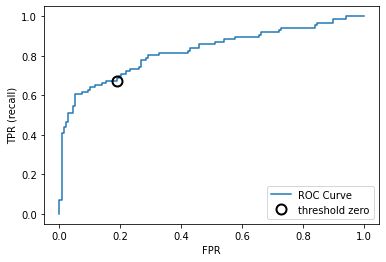

In [47]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, lr.decision_function(X_test))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# 找到最接近于0的阈值
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

In [50]:
auc = roc_auc_score(y_test, lr.predict(X_test))
print(f"Linear Regression AUC={auc}")

Linear Regression AUC=0.7459684264131726


## 思考

- 划分数据集的方法有哪些？
- 为什么使用分层抽样，这样的好处有什么？
- 为什么线性模型可以进行分类任务，背后是怎么的数学关系
- 对于多分类问题，线性模型是怎么进行分类的
- 预测标签的概率对我们有什么帮助
- k折越多的情况下会带来什么样的影响？
- 对于多分类问题如何绘制ROC曲线

# 四、使用梯度提升树对特征重要度进行分析

## 1. 导入库

In [51]:
import tensorflow as tf
tf.random.set_seed(123)

## 2. 构建输入数据的pipeline

In [56]:
# [Pclass	Age	SibSp	Parch	Fare	Sex_female	Sex_male	Embarked_C	Embarked_Q	Embarked_S]
df_train_labels = df_train['Survived']
df_train_data = df_train.drop(columns=["Survived", "Name", "Sex_female", "Sex_male", "Ticket", "Embarked_C", "Embarked_Q", "Embarked_S", "Embarked_0"])
df_train_data.head()
dftrain = df_train_data

fc = tf.feature_column
CATEGORICAL_COLUMNS = ['Sex', 'SibSp', 'Parch', 'Pclass', 'Embarked', "Cabin"]
NUMERIC_COLUMNS = ['Age', 'Fare']

def one_hot_cat_column(feature_name, vocab):
    return fc.indicator_column(
        fc.categorical_column_with_vocabulary_list(feature_name, vocab))

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    # 需要使用独热编码（one-hot-encoding）处理非数值特征。
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(fc.numeric_column(feature_name, dtype=tf.float32))

In [53]:
# dftrain = X_train
y_train = y_train
dfeval = X_test
y_eval = y_test

In [54]:
# 当数据集小的时候，将整个数据集作为一个 batch。
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        # 训练时让数据迭代尽可能多次 （n_epochs=None）。
        dataset = (dataset
                    .repeat(n_epochs)
                    .batch(NUM_EXAMPLES))
        return dataset
    return input_fn

# 训练并评估输入函数。
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

## 3. 训练模型

In [55]:
params = {
  'n_trees': 50,
  'max_depth': 3,
  'n_batches_per_layer': 1,
  # 为了得到 DFCs，设置 center_bias = True。这将强制
  # 模型在使用特征（例如：回归中训练集标签的均值，分类中使
  # 用交叉熵损失函数时的对数几率）前做一个初始预测。
  'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# 训练模型。
est.train(train_input_fn, max_steps=100)

# 评估。
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

NameError: name 'feature_columns' is not defined

In [ ]:
in_memory_params = dict(params)
in_memory_params['n_batches_per_layer'] = 1
# 在内存中的输入方程请不要对数据分批。
def make_inmemory_train_input_fn(X, y):
  y = np.expand_dims(y, axis=1)
  def input_fn():
    return dict(X), y
  return input_fn
train_input_fn = make_inmemory_train_input_fn(dftrain, y_train)

# 训练模型。
est = tf.estimator.BoostedTreesClassifier(
    feature_columns, 
    train_in_memory=True, 
    **in_memory_params)

est.train(train_input_fn)
print(est.evaluate(eval_input_fn))

## 4. 模型解释与可视化

这里使用到了一个概念，叫做`局部可解释性`（Local interpretability）；

根据 [Palczewska et al](https://arxiv.org/pdf/1312.1121.pdf) 和 Saabas 在 [解释随机森林（Interpreting Random Forests）](http://blog.datadive.net/interpreting-random-forests/) 中提出的方法，我们将所使用定向特征贡献（DFCs）来解释模型的决策行为。

使用以下语句输出 DFCs:

`pred_dicts = list(est.experimental_predict_with_explanations(pred_input_fn))`

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

In [ ]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

# 创建 DFCs 的 DataFrame。
labels = y_eval.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

In [ ]:
pred_dicts[:10]

In [ ]:
df_dfc.shape

DFC 有个不错的特性：贡献和 + 偏差（bias） = 给出样例的预测值。

In [ ]:
# DFCs的和 + 偏差（bias） == 可能性
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values, probs.values)

为单个乘客绘制 DFCs，绘图时按贡献的方向性对其进行涂色并添加特征的值。

In [ ]:
# 绘制模版 :)
def _get_color(value):
    """正的 DFCs 标为绿色，负的为红色。"""
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red

def _add_feature_values(feature_values, ax):
    """在图的左侧显示特征的值"""
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
    fontproperties=font, size=12)

def plot_example(example):
    TOP_N = 8 # 显示前8个特征。
    sorted_ix = example.abs().sort_values()[-TOP_N:].index  # 按值排序。
    example = example[sorted_ix]
    colors = example.map(_get_color).tolist()
    ax = example.to_frame().plot(kind='barh',
                          color=[colors],
                          legend=None,
                          alpha=0.75,
                          figsize=(10,6))
    ax.grid(False, axis='y')
    ax.set_yticklabels(ax.get_yticklabels(), size=14)

    # 添加特征的值。
    _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)
    return ax

In [ ]:
# 绘制结果。
ID = 182
example = df_dfc.iloc[ID]  # 从评估集中选择第 i 个样例。
TOP_N = 8  # 显示前8个特征。
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14)
plt.show()

更大的贡献值意味着对模型的预测有更大的影响。负的贡献表示此样例该特征的值减小了减小了模型的预测，正贡献值表示增加了模型的预测。

接下来使用小提琴图（violin plot）来绘制该样例的 DFC 并与整体分布比较。

In [ ]:
# 绘制代码模版。
def dist_violin_plot(df_dfc, ID):
    # 初始化画布。
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # 创建样例 DataFrame。
    TOP_N = 8  # 显示前8个特征。
    example = df_dfc.iloc[ID]
    ix = example.abs().sort_values()[-TOP_N:].index
    example = example[ix]
    example_df = example.to_frame(name='dfc')

    # 添加整个分布的贡献。
    parts=ax.violinplot([df_dfc[w] for w in ix],
                 vert=False,
                 showextrema=False,
                 widths=0.7,
                 positions=np.arange(len(ix)))
    face_color = sns_colors[0]
    alpha = 0.15
    for pc in parts['bodies']:
        pc.set_facecolor(face_color)
        pc.set_alpha(alpha)

    # 添加特征的值。
    _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)

    # 添加局部贡献。
    ax.scatter(example,
              np.arange(example.shape[0]),
              color=sns.color_palette()[2],
              s=100,
              marker="s",
              label='contributions for example')

    # 图例。
    # 生成小提琴图的详细图例。
    ax.plot([0,0], [1,1], label='eval set contributions\ndistributions',
          color=face_color, alpha=alpha, linewidth=10)
    legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large',
                     frameon=True)
    legend.get_frame().set_facecolor('white')

    # 调整格式。
    ax.set_yticks(np.arange(example.shape[0]))
    ax.set_yticklabels(example.index)
    ax.grid(False, axis='y')
    ax.set_xlabel('Contribution to predicted probability', size=14)

In [ ]:
dist_violin_plot(df_dfc, ID)
plt.title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
plt.show()

此外，第三方的工具，如：LIME 和 shap 也可以帮助理解模型的各个预测。